# Lecture 18: (Supervised) Classification

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture18.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.

##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.  
 
- code taken and modified from 
[astroML fig. 9.18](http://www.astroml.org/book_figures/chapter9/fig_star_quasar_ROC.html) 

<a id='toc'></a>

## This notebook includes:
 

[Introduction to Supervised Classification](#intro)
- supervised vs. unsupervised classification
- types of classifiers: generative vs. discriminative
- classification loss
- ROC curves 

[An example of a discriminative classifier: Support Vector Machine classifier](#svm)

[An example of a generative classifier: star/galaxy separation using Gaussian Naive Bayes classifier](#GNBsg)

[Comparison of many methods using ROC curves](#roc)


## Introduction to Supervised Classification <a id='basics'></a>
[Go to top](#toc)

In density estimation, we estimate joint probability distributions from multivariate data sets to identify the inherent clustering. This is essentially **unsupervised classification**. In other words, this method is search for unknown structure in your (multi-dimensional) dataset.

If we have labels for some of these data points (e.g., an object is tall, short, red, or blue), we can develop a relationship between the label and the properties of a source. This is **supervised classification**. In other words, this method is finding objects in 
your (multi-dimensional) dataset that "look like" objects in your training set. 

Classification, regression, and density estimation are all related. For example, the regression function $\hat{y} = f(y|\vec{x})$ is the best estimated value of $y$ given a value of $\vec{x}$. In classification $y$ is categorical and $f(y|\vec{x})$ is called the _discriminant function_

- Using density estimation for classification is referred to as <u>_generative classification_</u> (we have a full model of the density for each class or we have a model which describes how data could be generated from each class). 

- Classification that finds the decision boundary that separates classes is called <u> _discriminative classification_ </u>

Both have their place in astrophysical classification.

### Classification loss: how well are we doing?

The first question we need to address is how we score (define the success of our classification).

We can define a _loss function_. A zero-one loss function assigns a value of one for a misclassification and zero for a correct classification (i.e. we will want to minimize the loss).

If $\hat{y}$ is the best guess value of $y$, the classification loss, $L(y,\widehat{y})$, is

 $$L(y,\widehat{y}) = \delta(y \neq \widehat{y})$$

which means

$\begin{eqnarray} L(y,\hat{y}) & = & \left\{ \begin{array}{cl} 1 & \mbox{if $y\neq\hat{y}$}, \\  0 & \mbox{otherwise.}       	           \end{array} \right. \end{eqnarray}$

Note the obvious implication: the minumum of this loss function is zero and its maximum is the sample size.

The expectation (mean) value of the loss $\mathbb{E} \left[ L(y,\hat{y}) \right] = p(y\neq \hat{y})$  is called the <u>classification risk</u> 

This is related to regression loss functions: $L(y, \hat{y}) = (y - \hat{y})^2$ and <u>risk<u> $\mathbb{E}[(y - \hat{y})^2]$.

We can then define:

> $ {\rm completeness} = {\rm true\ positive\ rate} = \frac{\rm true\ positives}
  {\rm true\ positives + false\ negatives}
$

> $  {\rm contamination} = {\rm false\ positive\ rate} = \frac{\rm false\ positives}
  {\rm true\ positives + false\ positives}.
$

### Types of classifiers

There are two basic types of classification methods: **generative** classification methods model the underlying density field (i.e. they relies on density estimation methods, such as Gaussian Mixture Model), and **discriminative** classification methods (e.g. Support Vector Machine) which focus on finding the decision boundary which separates classes directly.  The former are easier to interpret, the latter often work better in high-D cases.


![](figures/genclass.png)

![](figures/discrimclass.png)

### Comparing the performance of classifiers

Best performance is a bit of a subjective context-dependent topic (e.g. star-galaxy separation for correlation function studies vs. star-galaxy separation for  Galactic streams studies). We trade contamination as a function of completeness and this is science dependent.

**ROC curves: Receiver Operating Characteristic curves**

- Plot the true-positive vs the false-positive rate

- Initially used to analyze radar results in WWII (a very productive era for statistics...).

- One concern about ROC curves is that they are sensitive to the relative sample sizes (if there are many more background events than source events small false positive results can dominate a signal). For these cases we we can plot efficiency (1 - contamination) vs completeness

### Which classification method to use? 

There is no general answer because the performance of a method
depends on the properties of your dataset and what is the goal
of your classification (a good workshop has many different types
of hammers, screwdrivers etc. in its toolbox!). 

We will illustrate here a number of methods and compare 
their performace on a hard dataset using ROC curves: 

- LinearDiscriminantAnalysis
- QuadraticDiscriminantAnalysis
- Gaussian Naive Bayes 
- Gaussian Mixture Model Bayes
- K nearest neighbors (KNN) classifier
- Decision Tree Classifier
- Logistic Regression

The "hard problem" is drawn from SDSS: selection of RR Lyrae stars
using single-epoch photometry. The problem is hard because it is 
imbalanced: there are vastly more non-RR Lyrae stars than RR Lyrae
stars with similar colors. For more astrophysical and other details, please see [this paper](http://faculty.washington.edu/ivezic/Publications/203458.web.pdf). 

**Note** Image classification using Convolutional Neural Networks
is a rapidly developing topic! We cannot do it justice in this short course, but we will say a few words about it and show an example in our last lecture. 

In [14]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve

from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined

 ## An example of a discriminative classifier: Support Vector Machine classifier <a id='svm'></a>
[Go to top](#toc)

This is a rather general (multi-purpose) hammer! 

## Support Vector Machines 

Find the hyperplane that maximizes the distance of the closest point from either class. This distance is the margin (width of the line before it hits a point). We want the line that maximizes the margin (m).

The points on the margin are called _support vectors_

If we assume $y \in \{-1,1\}$, (+1 is maximum margin, -1 is minimum, 0 is the decision boundary)

The maximum is then just when $\beta_0 + \beta^T x_i = 1$ etc

The hyperplane which maximizes the margin is given by finding

$$
\max_{\beta_0,\beta}(m) \;\;\;
  \mbox{subject to} \;\;\; \frac{1}{||\beta||} y_i ( \beta_0 + \beta^T x_i )
  \geq m \,\,\, \forall \, i.
$$

The constraints can be written as $y_i ( \beta_0 + \beta^T x_i ) \geq m ||\beta|| $. 

Thus the optimization problem is equivalent to minimizing
$$
\frac{1}{2} ||\beta|| \;\;\; \mbox{subject to} \;\;\; y_i
  ( \beta_0 + \beta^T x_i ) \geq 1 \,\,\, \forall \, i.
$$

This optimization  is a _quadratic programming_ problem (quadratic objective function with linear constraints).


Note that because SVM uses a metric which maximizes the margin rather than a measure over all points in the data sets, it is similar in spirit to the rank-based estimators 


- The median of a distribution is unaffected by even large perturbations of outlying points, as long as those perturbations do not cross the boundary.
- In the same way, once the support vectors are determined, changes to the positions or numbers of points beyond the margin will not change the decision boundary.  For this reason, SVM can be a very powerful tool for discriminative classification.

- This is why there is a high completeness compared to the other methods: it does not matter that the background sources outnumber the RR Lyrae stars by a factor of $\sim$200 to 1. It simply determines the best boundary between the small RR Lyrae clump and the large background clump.
- This completeness, however, comes at the cost of a relatively large contamination level.

- SVM is not scale invariant so it often worth rescaling the data to [0,1] or to whiten it to have a mean of 0 and variance 1 (remember to do this to the test data as well!)
- The data dont need to be separable (we can put a constraint in minimizing the number of "failures")

### Dataset
We will use the RR Lyrae dataset. We get the data here, and split it into training and testing sets,
and then use the same sets for all the examples below.

In [15]:
#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

completeness [1. 1. 1. 1.]
contamination [0.90108303 0.83901293 0.83573141 0.81561238]


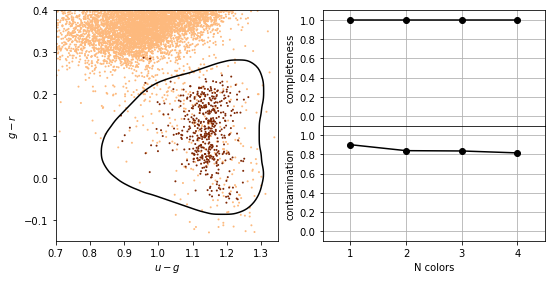

In [16]:
# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X_tr = X[::5]
#y_tr = y[::5]


#----------------------------------------------------------------------
# Fit Kernel SVM
Ncolors = np.arange(1, X.shape[1] + 1)

def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='rbf', gamma=20.0, class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# smooth the boundary
from scipy.ndimage import gaussian_filter
Z = gaussian_filter(Z, 2)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Gaussian Naive Bayes <a id='GNBsg'></a>
[Go to top](#toc)

In Gaussian naive Bayes $p_k(x^i)$ are modeled as one-dimensional normal distributions, with means $\mu^i_k$ and widths $\sigma^i_k$. The naive Bayes estimator is then

$$\hat{y} = \arg\max_{y_k}\left[\ln \pi_k - \frac{1}{2}\sum_{i=1}^N\left(2\pi(\sigma^i_k)^2 + \frac{(x^i - \mu^i_k)^2}{(\sigma^i_k)^2} \right) \right]$$

<b> Note: this is the log of the Bayes criterion with no normalization constant </b>

This classifier is easy to implement and very robust. However, it works well only when the distributions are aligned with coordinate axes (that is, when "measurement types" are quite unrelated to each other, such as brightness and size in this example). For a deeper discussion of this problem, see [this paper on star-galaxy separation](http://faculty.washington.edu/ivezic/Publications/Slater_2020_AJ_159_65.pdf). 

In [17]:
from astroML.datasets import fetch_imaging_sample

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()

    objtype = data['type']

    stars = data[objtype == 6][:Nstars]
    
    galaxies = data[objtype == 3][:Ngals]

    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)), np.ones(len(galaxies))])

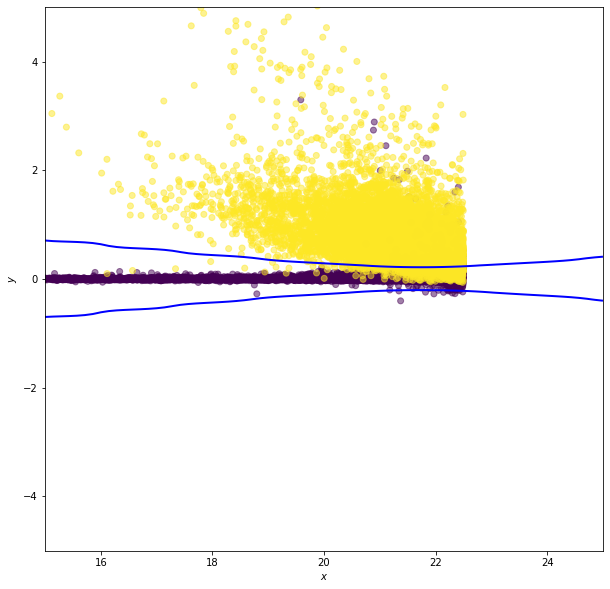

In [18]:
data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

#------------------------------------------------------------
# Fit the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (15, 25)
ylim = (-5, 5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, zorder=2, alpha=0.5)

ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='blue')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

### Here is a generalization of Gaussian Naive Bayes Classifier to Gaussian Mixture Bayes Classifier

In [19]:
from sklearn.mixture import GaussianMixture

class GMMBayes(GaussianNB):
    """GaussianMixture Bayes Classifier

    This is a generalization to the Naive Bayes classifier: rather than
    modeling the distribution of each class with axis-aligned gaussians,
    GMMBayes models the distribution of each class with mixtures of
    gaussians.  This can lead to better classification in some cases.

    Parameters
    ----------
    n_components : int or list
        number of components to use in the GaussianMixture. If specified as
        a list, it must match the number of class labels. Default is 1.
    **kwargs : dict, optional
        other keywords are passed directly to GaussianMixture
    """

    def __init__(self, n_components=1, **kwargs):
        self.n_components = np.atleast_1d(n_components)
        self.kwargs = kwargs

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

        if n_samples != y.shape[0]:
            raise ValueError("X and y have incompatible shapes")

        self.classes_ = np.unique(y)
        self.classes_.sort()
        unique_y = self.classes_

        n_classes = unique_y.shape[0]

        if self.n_components.size not in (1, len(unique_y)):
            raise ValueError("n_components must be compatible with "
                             "the number of classes")

        self.gmms_ = [None for i in range(n_classes)]
        self.class_prior_ = np.zeros(n_classes)

        n_comp = np.zeros(len(self.classes_), dtype=int) + self.n_components

        for i, y_i in enumerate(unique_y):
            if n_comp[i] > X[y == y_i].shape[0]:
                warnstr = ("Expected n_samples >= n_components but got "
                           "n_samples={0}, n_components={1}, "
                           "n_components set to {0}.")
                warnings.warn(warnstr.format(X[y == y_i].shape[0], n_comp[i]))
                n_comp[i] = y_i
            self.gmms_[i] = GaussianMixture(n_comp[i], **self.kwargs).fit(X[y == y_i])
            self.class_prior_[i] = np.float(np.sum(y == y_i)) / n_samples

        return self

    def _joint_log_likelihood(self, X):

        X = np.asarray(np.atleast_2d(X))
        logprobs = np.array([g.score_samples(X) for g in self.gmms_]).T
        return logprobs + np.log(self.class_prior_)

## Comparison of many methods using ROC curves <a id='roc'></a>
[Go to top](#toc)
 

In [20]:
#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


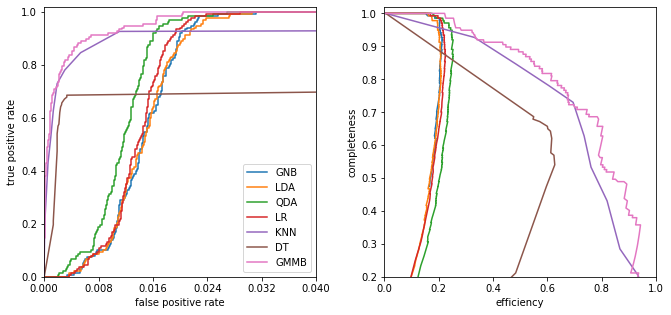

In [21]:
#------------------------------------------------------------
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)


# ax2 will show roc curves
ax1 = plt.subplot(121)

# ax1 will show completeness/efficiency
ax2 = plt.subplot(122)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax1.plot(fpr, tpr, label=labels[name])

    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

plt.show()

Let's now say a few more words about these classification methods: what exactly do they do? 


## Linear and quadratic discriminant analysis

Linear discriminant analysis (LDA) assumes  the class distributions have identical
covariances for all $k$ classes (all classes are a set of shifted Gaussians). The
optimal classifier is derived from the log of the class
posteriors 

$$g_k(\vec{x}) = \vec{x}^T \Sigma^{-1} \vec{\mu_k} - \frac{1}{2}\vec{\mu_k}^T \Sigma^{-1} \vec{\mu_k} + \log \pi_k,
$$

with $\vec{\mu_k}$ the mean of class $k$ and $\Sigma$ the covariance of the
Gaussians. The class dependent covariances that would normally give rise to a quadratic dependence on
$\vec{x}$ cancel out if they are assumed to be constant. The Bayes classifier is, therefore, linear with respect to $\vec{x}$.

The discriminant boundary between classes is the line that minimizes
the overlap between Gaussians

$$  g_k(\vec{x}) - g_\ell(\vec{x}) = \vec{x}^T \Sigma^{-1} (\mu_k-\mu_\ell)  - \frac{1}{2}(\mu_k - \mu_\ell)^T \Sigma^{-1}(\mu_k -\mu_\ell)  + \log (\frac{\pi_k}{\pi_\ell}) = 0. $$



Relaxing the requirement that the covariances of the
Gaussians are constant, the discriminant function
becomes quadratic in $x$:

$$ g(\vec{x}) = -\frac{1}{2} \log | \Sigma_k |   - \frac{1}{2}(\vec{x}-\mu_k)^T C^{-1}(\vec{x}-\mu_k) + \log \pi_k. $$

This is sometimes known as _quadratic discriminant analysis_ (QDA)

In [22]:
#----------------------------------------------------------------------
# perform LinearDiscriminantAnalysis
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

completeness [0.48175182 0.67153285 0.67153285 0.67153285]
contamination [0.85300668 0.80590717 0.80467091 0.80590717]


In [23]:
# perform QuadraticDiscriminantAnalysis
qclassifiers = []
qpredictions = []

for nc in Ncolors:
    qlf = QuadraticDiscriminantAnalysis()
    qlf.fit(X_train[:, :nc], y_train)
    qy_pred = qlf.predict(X_test[:, :nc])

    qclassifiers.append(qlf)
    qpredictions.append(qy_pred)

qpredictions = np.array(qpredictions)

qcompleteness, qcontamination = completeness_contamination(qpredictions, y_test)

print("completeness", qcompleteness)
print("contamination", qcontamination)

completeness [0.48175182 0.68613139 0.73722628 0.78832117]
contamination [0.85201794 0.79249448 0.77555556 0.75675676]


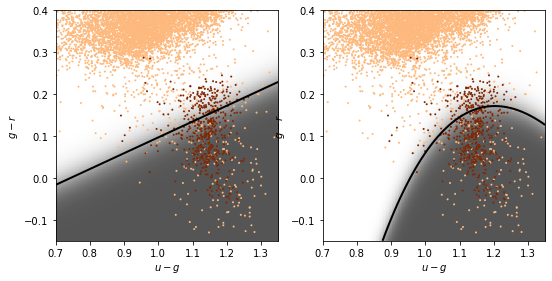

In [24]:
#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
qlf = qclassifiers[1]

xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))


Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

QZ = qlf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
QZ = QZ[:, 1].reshape(xx.shape)



#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# right plot: qda
ax = fig.add_subplot(122)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(QZ, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, QZ, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')


plt.show()

## GMM and Bayes classification

The natural extension to the Gaussian assumptions is to use GMM's to learn the density distribution. 

The number of Gaussian components $K$ must be chosen for each class independently


completeness [[0.48175182 0.68613139 0.73722628 0.78832117]
 [0.         0.11678832 0.43065693 0.68613139]]
contamination [[0.85201794 0.79249448 0.77605322 0.75675676]
 [0.         0.33333333 0.14492754 0.21666667]]


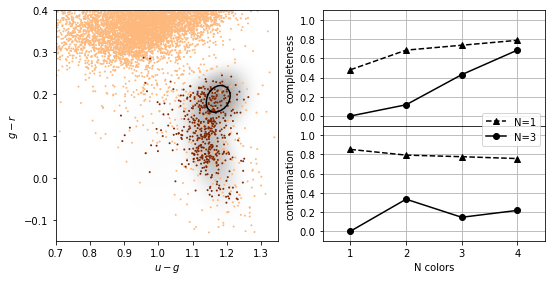

In [25]:
# GMM-bayes takes several minutes to run, and is order[N^2]
# where N is the sample size
#  truncating the dataset can be useful for experimentation.
#X_tr = X[::10]
#y_tr = y[::10]

#----------------------------------------------------------------------
# perform GMM Bayes
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 3]


def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, completeness[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, contamination[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

You can see that 1-component classifier is pretty bad, while with 
3 components, the performance significantly improves.

## K-nearest neighbours

As with density estimation (and kernel density estimation)  the intuitive justification is that $p(y|x) \approx p(y|x')$ if $x'$ is very close to $x$.  

The number of neighbors, $K$, regulates the complexity of the classification. In simplest form, a majority rule classification is adopted, where each of the $K$ points votes on the classification. Increasing $K$ decreases the variance in the classification but at the expense of an increase in the bias.  

Weights can be assigned to  individual votes by weighting the vote by the distance to the nearest point.

completeness [[0.22627737 0.3649635  0.46715328 0.54014599]
 [0.00729927 0.23357664 0.40145985 0.53284672]]
contamination [[0.78014184 0.53271028 0.44347826 0.41732283]
 [0.875      0.44827586 0.24657534 0.23958333]]


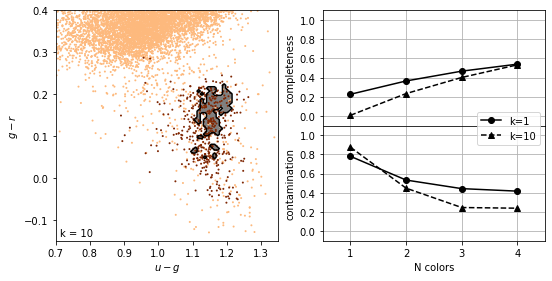

In [26]:
#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 10]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "k = %i" % kvals[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()